# Metadata

```
Course:  DS 5001
Module:  03 Lab
Topic:   Baby Babel
Author:  R.C. Alvarado
Date:    29 January 2023 (revised)
```

**Purpose**: Implements the Library of Babel with a small symbol set and message length.

# Set Up

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.core.display import HTML

In [2]:
sns.set()

In [3]:
data_home = '../data'

# Mini Babel

We create a miniature Library of Babel, one based on only four characters, and a message length of six. 

## The Symbol Set

In [4]:
mini_alpha = list('abt ')

## All possible Messages of Length 6

This is a clumsy but visually effective way to demonstrate how the Library of Babel might have been constructed. It is essentially the cartesian product of the alphabet, multiplying by the length of the message.

In [5]:
mini_library_list = []
for L1 in mini_alpha:
    for L2 in mini_alpha:
        for L3 in mini_alpha:
            for L4 in mini_alpha:
                for L5 in mini_alpha:
                    for L6 in mini_alpha:
                        mini_library_list.append(''.join((L1,L2,L3,L4,L5,L6)))

How many books are in the library?

In [6]:
len(mini_library_list), len(mini_alpha) ** 6

(4096, 4096)

Can we find a specific book?

In [7]:
mini_library_list.index('at bat')

722

## The Pandas Way

Pandas provides a method -- `pd.MultiIndex.from_product()` -- to create a cartesian product of an arbitrary list of lists.

Let's create a library based on a book length $L = 6$.

In [8]:
L = 6

In [9]:
alpha_lists = [mini_alpha] * L
book_idx = pd.MultiIndex.from_product(alpha_lists)
mini_library = pd.DataFrame(index=book_idx)\
    .reset_index()\
    .sum(1)\
    .to_frame('book')
    #.apply(lambda x: ''.join(x), 1)\

In [10]:
mini_library

,book
0,aaaaaa
1,aaaaab
2,aaaaat
3,aaaaa
4,aaaaba
...,...
4091,t
4092,a
4093,b
4094,t


Should be the same as $|a|^L$ where $|a|$ is the symbol set size and $L$ is the average message length.

In [11]:
len(mini_library) == len(mini_alpha)**L

True

In [12]:
mini_library[mini_library.book == 'at bat']

,book
722,at bat


## Probability of a book

In [13]:
N = len(mini_library)

In [14]:
assert N == len(mini_alpha)**L

In [15]:
p_book = 1 / N

In [16]:
p_book

0.000244140625

## Entropy of `mini_library`

Max Entropy: $H_{max} = \sum_N\frac{1}{N}\log_2(\frac{N}{1}) = N\frac{1}{N}\log_2(\frac{N}{1}) = \log_2(N)$

In [17]:
H_max = np.log2(N)

In [18]:
H_max

12.0

## Sample text

In [19]:
mini_text = mini_library.sample(100, replace=True).book.str.cat(sep=' ')

In [20]:
mini_text

' tbtat bttbt  a baab a ttta  aata   b  ta abt ab  babat btb bb aab tt abtaat  abaat tabt   t abba  t  ab tabta  tbat t  bba t  tbtb  ttttab tatbta a tatt tabba  ttab t  btttt tatbbt a atbt tt bab  a  bb  tatbb tb bab  a  bb  ta tb  bb  a    ttt ta   b tatatb  bb at t ta b bbb  t aaaaa   bbtbb btatat  bbta  a aaat tta tt tabaaa  a a b aaaa b  tbbba t aab  atbt b  aaaa  tb bta bb   t ba bbb t atbt tbabb   ttbbt ttbtbt ab   b  a  bb  tt b  atttbb tt  at bb aa    atbb a  ata abbaaa aab a  b  bbt bt a a bt a b t   tb b batt aaaaab btab    bttb  ttbbta b t bb a btt  bb  tt aabtb  baaabb  t ba    tb   abb a  ta t a bbb bt  a  ta atbtat ta  aa att    tabt    abt a bbaab  t ba b aba  t abtbtb aattbb'

In [21]:
display(HTML(mini_text))

# Bigger Babel

In [22]:
class UnigramModel():
    """A simple character level language model. A language model is just
    the sample space of the symbol system with associated probabilities."""
    
    alpha:[] = list(' abcdefghijklmnopqrstuvwxyz')
    
    def __init__(self):
        self.model = pd.DataFrame(index=self.alpha)
        self.model.index.name = 'char'
        self.model['n'] = 1
        self.model['p_x'] = 1 / len(self.alpha)
        
    def update_weights(self, char_str=''):
        self.char_str = char_str.lower()
        self.chars = pd.Series(list(self.char_str))
        self.chars = self.chars[self.chars.isin(self.alpha)]       
        self.model['n'] = self.chars.value_counts()
        self.model['p_x'] = self.model.n / self.model.n.sum()

In [23]:
UGM = UnigramModel()

In [24]:
UGM.model

,n,p_x
char,,
,1,0.037037
a,1,0.037037
b,1,0.037037
c,1,0.037037
d,1,0.037037
e,1,0.037037
f,1,0.037037
g,1,0.037037
h,1,0.037037


In [25]:
class Babel():
    """Generate messages based on a character level language model."""

    msg_len:int = 40 * 80
    use_html = True
    
    def __init__(self, UGM:UnigramModel=UGM):
        self.UGM = UGM
        
    def get_message(self):
        self.msg = self.UGM.model.sample(self.msg_len, weights='p_x', replace=True).index.str.cat()
        if self.use_html:
            self.msg = f"<div style='width:6in;font-size:14pt;font-family:monospace;'>{self.msg}</div>"
            
    def print_message(self):
        if self.use_html:
            display(HTML(self.msg))
        else:
            display(self.msg)

In [26]:
B1 = Babel(UGM)

In [27]:
B1.get_message()
B1.print_message()

# Add Data to Model

## Import corpus

In [28]:
text_csv = f'{data_home}/output/austen-combo.csv'

In [29]:
text_df = pd.read_csv(text_csv)

In [30]:
text_df.head()

,book_id,chap_num,para_num,sent_num,token_num,token_str,term_str
0,1,1,1,0,0,The,the
1,1,1,1,0,1,family,family
2,1,1,1,0,2,of,of
3,1,1,1,0,3,Dashwood,dashwood
4,1,1,1,0,4,had,had


## Convert to one big string

In [31]:
text_str = text_df.token_str.str.cat(sep=' ')

In [32]:
text_str[:80]

'The family of Dashwood had long been settled in Sussex Their estate was large an'

In [33]:
CHARS = pd.DataFrame(dict(char_token=list(text_str)))
CHARS['char_type'] = CHARS.char_token.str.lower()
CHARSET = CHARS.char_type.value_counts().to_frame('n')

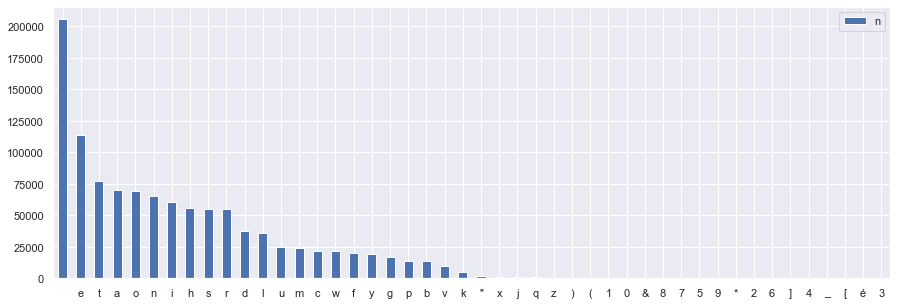

In [58]:
CHARSET.plot.bar(rot=0, figsize=(15,5));

## Update weights in model

In [59]:
UGM.update_weights(text_str)

In [60]:
UGM.model.head()

,n,p_x
char,,
,205600,0.187735
a,69746,0.063686
b,13643,0.012458
c,21513,0.019644
d,37509,0.034250


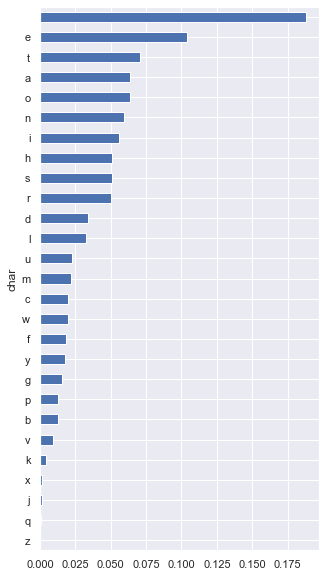

In [37]:
UGM.model.p_x.sort_values().plot(kind='barh', figsize=(5,10));

In [61]:
B1.get_message()
B1.print_message()

# Create Bigram Model

The index is the sample space.

In [62]:
class BigramModel():
    
    alpha:[] = list(' abcdefghijklmnopqrstuvwxyz')
    
    def __init__(self):
        self.idx = pd.MultiIndex.from_product([self.alpha, self.alpha], names=['char_x', 'char_y'])
        self.model = pd.DataFrame(dict(n=1, p_xy=(1/len(self.idx))), index=self.idx).sort_index()
    
    def update_weights(self, text_str):
        char_list = [char for char in text_str if char in self.alpha]
        df_cols = dict(
            char_x = [' '] + char_list,
            char_y = char_list + [' ']
        )
        self.model['n'] = pd.DataFrame(df_cols).value_counts()\
            .to_frame()
        self.model.n = self.model.n.fillna(0)
        self.model.n += 1 # LaPlace smoothing
        self.model['p_xy'] = self.model.n / self.model.n.sum()
        
    def add_conditional_probs(self):
        self.model['p_yGx'] = self.model.groupby('char_x')\
            .apply(lambda row: row.n / row.n.sum())\
            .to_frame('p_yGx').droplevel(0)
        
    def get_conditional_entropy(self):
        """Computes the entropy for each character of the distribution of following characters."""
        self.H = self.model.groupby('char_x').apply(lambda row: row.p_yGx * np.log2(1/row.p_yGx))\
            .droplevel(0).to_frame('h_yGx')\
            .groupby('char_x').h_yGx.sum().to_frame()

In [63]:
BGM = BigramModel()

## Get Data to Estimate Model

In [64]:
BGM.update_weights(text_str)

## Add Conditional Probabilities

In [65]:
BGM.add_conditional_probs()

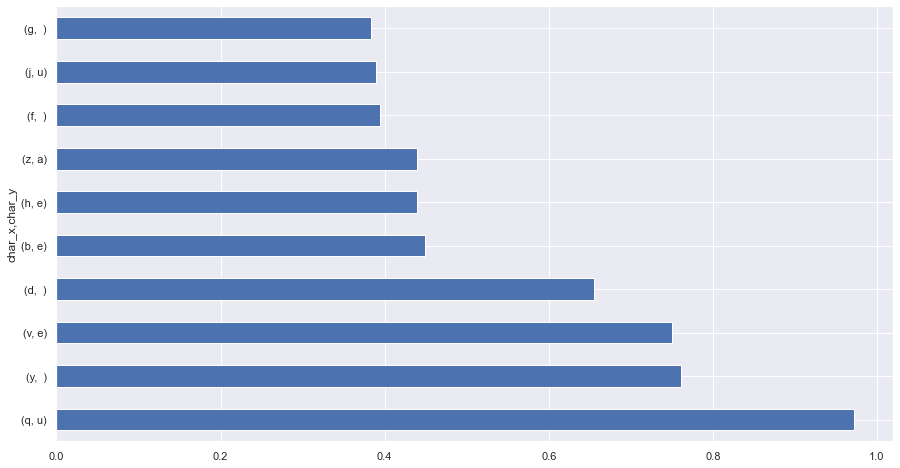

In [68]:
BGM.model.p_yGx.sort_values(ascending=False).head(10).plot.barh();

## Get conditional entropy of characters as antecendents

Note that all the vowels have high entropy rates.

In [83]:
BGM.get_conditional_entropy()

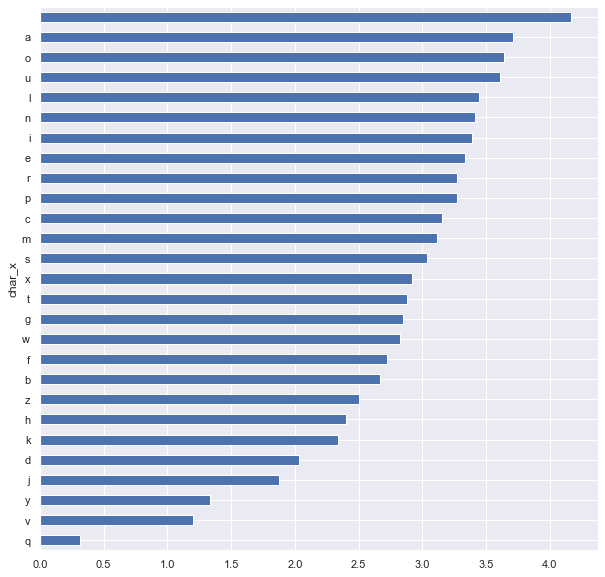

In [45]:
BGM.H.h_yGx.sort_values().plot.barh(figsize=(10,10));

## Look at Examples

In [100]:
X = BGM.model.p_yGx.unstack()
X = round(X * 100, 2)

In [101]:
X.style.format("{:.2f}").background_gradient(cmap='YlGnBu', axis=None)

char_y,,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
char_x,,,,,,,,,,,,,,,,,,,,,,,,,,,
,2.18,12.18,4.40,3.40,2.57,3.13,3.45,1.36,9.07,5.52,0.22,0.50,2.47,3.97,3.10,6.78,2.39,0.22,2.61,7.45,12.74,1.31,0.78,6.73,0.02,1.44,0.01
a,5.89,0.00,2.09,2.75,5.84,0.02,1.11,2.16,0.01,4.11,0.00,1.22,7.38,2.28,20.09,0.04,2.17,0.00,10.66,11.61,12.64,0.82,3.30,0.84,0.01,2.90,0.05
b,0.27,3.62,0.39,0.01,0.09,44.97,0.01,0.01,0.06,1.59,1.75,0.01,11.87,0.27,0.01,6.77,0.01,0.01,3.92,1.69,1.13,10.63,0.03,0.01,0.01,10.88,0.01
c,0.50,9.07,0.00,2.14,0.01,18.71,0.00,0.00,17.56,4.24,0.00,2.90,2.39,0.00,0.00,23.56,0.00,0.99,2.92,0.08,9.56,3.54,0.00,0.00,0.00,1.77,0.00
d,65.49,2.16,0.01,0.01,0.96,10.62,0.10,0.62,0.01,6.71,0.02,0.01,1.08,0.53,0.33,4.12,0.00,0.00,1.19,1.87,0.01,1.12,0.35,0.79,0.00,1.91,0.00
e,33.28,4.62,0.04,2.20,7.70,3.21,0.91,0.46,0.19,1.58,0.04,0.12,4.12,2.06,8.96,0.12,0.77,0.25,16.40,5.31,2.66,0.02,2.21,0.57,0.99,1.20,0.00
f,39.40,5.80,0.00,0.00,0.00,10.22,4.98,0.00,0.00,6.02,0.00,0.00,1.15,0.00,0.00,18.73,0.00,0.00,6.48,0.06,3.83,2.93,0.00,0.00,0.00,0.33,0.00
g,38.34,6.65,0.01,0.01,0.04,12.96,0.01,0.44,15.21,5.03,0.01,0.01,1.92,0.27,0.97,5.63,0.01,0.01,7.08,3.38,0.29,1.56,0.01,0.01,0.01,0.17,0.01
h,11.53,17.87,0.48,0.00,0.02,43.98,0.03,0.00,0.01,12.91,0.00,0.00,0.11,0.24,0.33,7.68,0.01,0.00,0.50,0.14,2.73,0.62,0.00,0.54,0.00,0.25,0.00


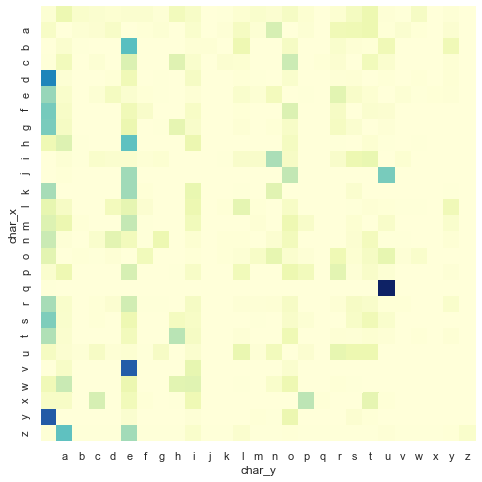

In [125]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data=BGM.model.p_yGx.unstack(), 
    cmap='YlGnBu', 
    square=True, 
    vmin=0, 
    vmax=1, 
    cbar=False);

In [103]:
def plot_char(char):
    global BGM
    h = BGM.H.loc[char].h_yGx.round(2)
    title = f"Char {char}, H={h}"
    BGM.model.loc[char].p_yGx.sort_values(ascending=False).plot.bar(figsize=(10,2), title=title);

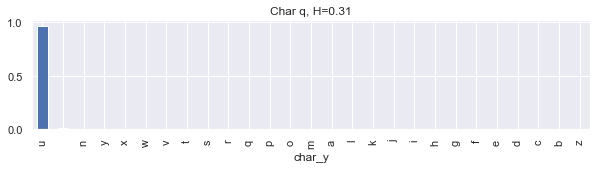

In [104]:
plot_char('q')

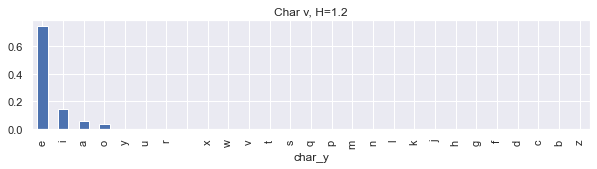

In [105]:
plot_char('v')

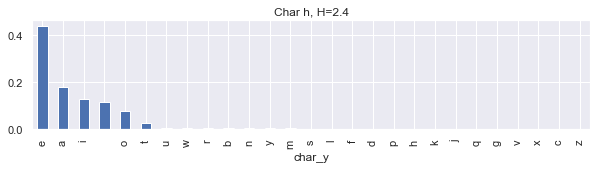

In [106]:
plot_char('h')

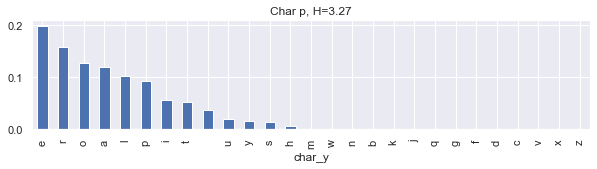

In [107]:
plot_char('p')

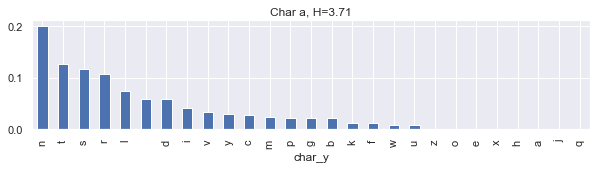

In [108]:
plot_char('a')

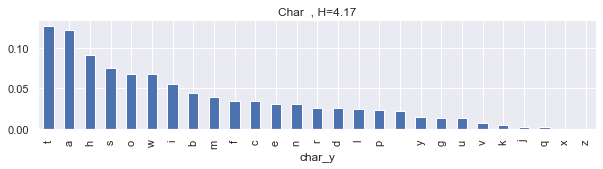

In [109]:
plot_char(' ')

# Generate text

In [113]:
english_words = set([word.strip().lower() 
                     for word in open(f"{data_home}/misc/english-words.txt", 'r')\
                        .readlines()])

In [114]:
class Babel2():
    """Generate messages based on a character level language model."""

    msg_len:int = 80 * 40
    use_html = True
    
    def __init__(self, BGM:BigramModel, english_words):
        self.BGM = BGM
        self.english_words = english_words
        
    def get_message(self):
        self.msg = ' '
        for i in range(self.msg_len):
            self.msg += self.BGM.model.loc[self.msg[-1]]\
                .sample(weights='p_yGx').index.values[0]
        self.tokens = pd.DataFrame(self.msg.split(), columns=['token_str'])
        self.vocab = self.tokens.token_str.value_counts().to_frame('n')
        self.vocab['en'] = False
        self.vocab.loc[self.vocab.index.isin(english_words), 'en'] = True
        self.vocab['len'] = self.vocab.index.str.len()
        self.tokens['en'] = self.tokens.token_str.map(self.vocab.en)
            
    def print_message(self):
        if self.use_html:
            html_msg = ''
            for token in self.msg.split():
                if token in english_words:
                    token = f"<b style='color:red;'>{token}</b>"
                html_msg += ' ' + token
            self.msg = f"<p style='color:gray;width:6in;font-size:14pt;font-family:monospace;'>{html_msg}</p>"            
            display(HTML(self.msg))
        else:
            display(self.msg)

In [115]:
B2 = Babel2(BGM, english_words)
B2.get_message()
B2.print_message()

# Look at Babel Vocab Stats

## English words

In [116]:
B2.vocab.loc[B2.vocab.en == True, ['n','len']]\
    .sort_values('n', ascending=False)

,n,len
he,11,2
the,6,3
me,5,2
be,4,2
and,3,3
her,2,3
in,2,2
a,2,1
or,2,2
as,2,2


## Type and token ratios

In [118]:
type_rate = round(B2.vocab[B2.vocab.en == True].n.count() / B2.vocab.n.count(), 2)
token_rate = round(B2.vocab[B2.vocab.en == True].n.sum() / B2.vocab.n.sum(), 2)
type_rate, token_rate, round(type_rate/token_rate, 2)

(0.07, 0.1, 0.7)

## Long words

In [119]:
B2.vocab.query("en == False").sort_values('len', ascending=False).head(20)

,n,en,len
rrchenoougaforenowhiviounte,1,False,27
thalitonsotoientofangat,1,False,23
werlmivewientadrount,1,False,20
ffowhertedasethompod,1,False,20
tigotucoronolleiompr,1,False,20
cinthtrenabyocoursl,1,False,19
arerorobunicoupive,1,False,18
ssuedilmilishad,1,False,15
theresucusowere,1,False,15
setoimorghesure,1,False,15


## Word lengths

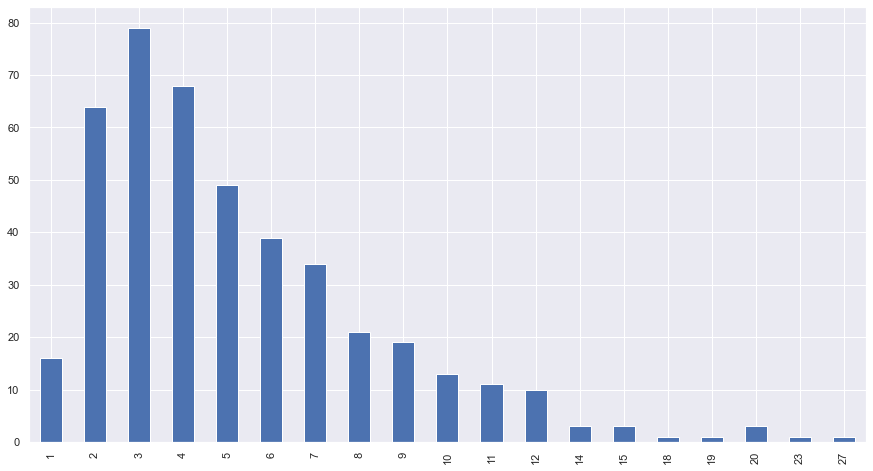

In [120]:
B2.vocab.len.value_counts().sort_index().plot.bar();

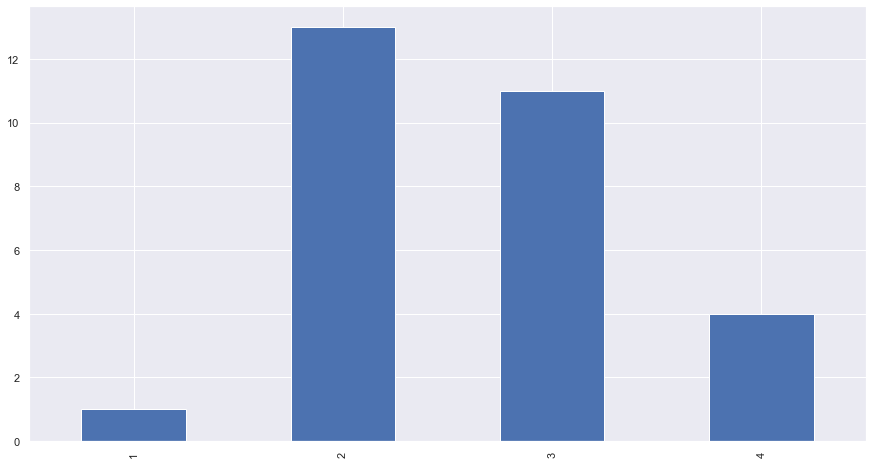

In [121]:
B2.vocab.query("en == True").len.value_counts().sort_index().plot.bar();

In [122]:
B2.vocab.len.mean()

5.307339449541284

In [123]:
B2.vocab[B2.vocab.en == True].len.mean()

2.6206896551724137

# Memorable passwords?

In [124]:
B2.vocab[(B2.vocab.en == False) & B2.vocab.len.isin([6,7,8])].sample(10)

,n,en,len
ongstom,1,False,7
intteim,1,False,7
intiny,1,False,6
offonoy,1,False,7
ousmatom,1,False,8
susitle,1,False,7
ostofoun,1,False,8
ioowere,1,False,7
accomed,1,False,7
ferseit,1,False,7


# Challenge

Build a language model using word lengths. Requires training a word length model from real English.